# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [104]:
# загрузка пакетов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split # разбивка выборки на обучающую и валидационную
from sklearn.preprocessing import StandardScaler # масштабирование
from sklearn.metrics import mean_squared_error # средняя квадратичная ошибка (MSE)
# Функция mean_squared_error принимает на вход только последовательности (Series). 
# Создать последовательность из средних значений можно так:
# predictions = pd.Series(target.mean(), index=target.index)
# rmse = mse**0.5 - корень из средней квадратичной ошибки (его необходимо минимизировать)
from sklearn.linear_model import LinearRegression # линейная регрессиия (по условию)



In [105]:
# загрузка данных
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [106]:
# посмотрим на данные
display(df_0.sample(10))
display(df_1.sample(10))
display(df_2.sample(10))

,id,f0,f1,f2,product
77719,OQyxj,1.311434,-0.390806,2.870755,81.452962
46360,ERjGN,1.116734,-0.510135,-0.842409,63.039674
7810,kmrUg,0.383558,-0.303198,7.590841,148.810905
1207,bF6MI,1.878740,0.138679,3.699660,149.843763
34157,tnxRY,-0.060117,0.705429,6.709464,100.042555
64787,0fkAL,0.598243,0.915059,0.639553,25.469440
84664,LoR5Y,0.478235,-0.477957,4.586196,156.857872
55185,lnpGn,0.198176,0.957288,-2.922813,89.489867
57271,qyUxG,1.919633,-0.336416,0.251950,46.530238
33245,TMvtm,0.025170,0.903953,-3.447791,116.468204


,id,f0,f1,f2,product
72140,Hbsot,-10.878171,-6.648300,1.999673,57.085625
48255,4O5P0,10.720578,-3.034012,-0.004768,0.000000
83345,88UZ9,-10.798711,-11.338982,3.003887,84.038886
53594,EHVbS,-7.901871,-4.144867,2.000869,57.085625
17489,KW6SH,0.989747,-4.386948,-0.000660,3.179103
18763,It0Ac,-12.057777,-2.303237,3.000403,84.038886
28218,opS01,4.552226,-17.392765,3.999682,107.813044
45257,2woJY,5.856896,-1.263503,0.995640,30.132364
81940,c65RF,11.618006,-2.290246,3.998256,107.813044
13839,LMOVg,9.247561,-0.593167,1.996861,53.906522


,id,f0,f1,f2,product
25952,DDngO,0.485428,1.643474,3.985457,86.712564
74409,Rjayz,-0.530173,0.079807,6.172318,114.634830
42932,dNTcJ,-0.678037,2.007469,-0.536417,77.016773
33052,biAkd,0.696867,-0.407383,-3.409472,80.960026
44035,HafUV,-1.106825,-0.826546,2.938541,85.738384
86,JITeV,-1.113754,-0.179279,5.944989,147.198142
15831,og79J,-0.432754,-1.672285,2.108807,59.533327
10927,4S0Ew,-0.704854,0.322829,1.848182,41.912113
18631,O2fSf,1.626727,3.520031,0.195380,91.354129
52480,Fzgg4,-2.257173,-2.841505,-2.203483,88.483099


Во всех трех df есть неинформативная переменная "id", которая не поможет при создании модели. А также во всех информативных переменных "f0", "f1", "f2" встречаются отрицательные значения.

In [107]:
# удалим переменную "id" из всех df
df_0 = df_0.drop('id', axis=1)
df_1 = df_1.drop('id', axis=1)
df_2 = df_2.drop('id', axis=1)

In [108]:
# проверим нет ли пропусков
df_0.info()
df_1.info()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1 

Пропусков нет. Формат данных - числа с дробной частью.

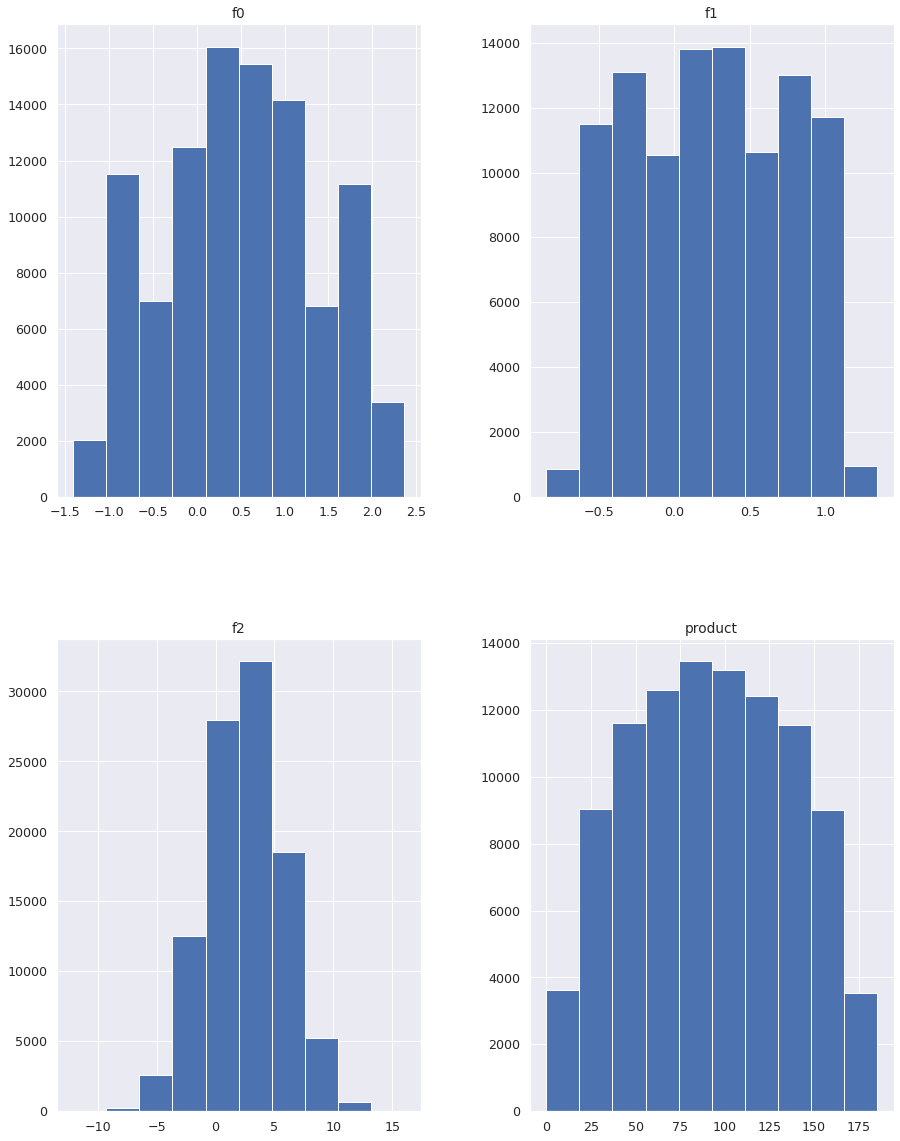

In [109]:
df_0.hist(figsize=(15, 20));

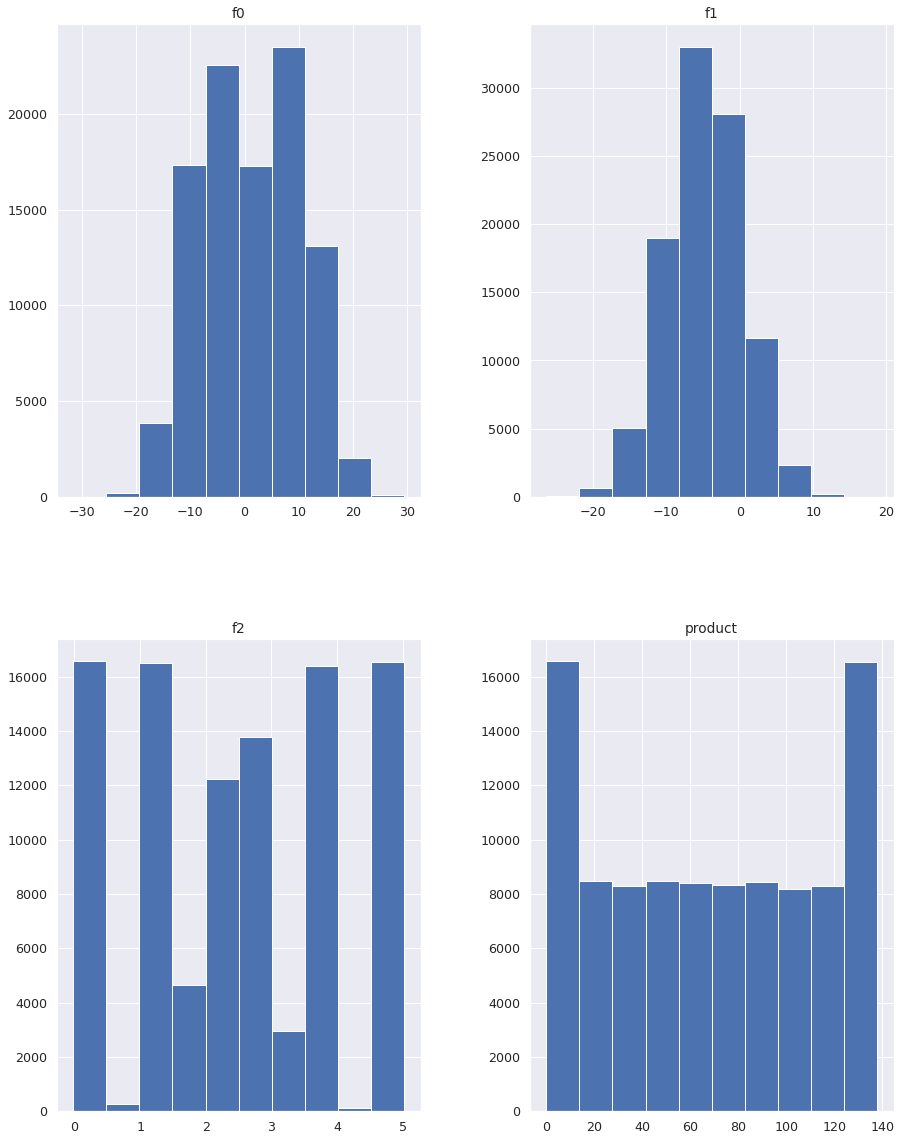

In [110]:
df_1.hist(figsize=(15, 20));

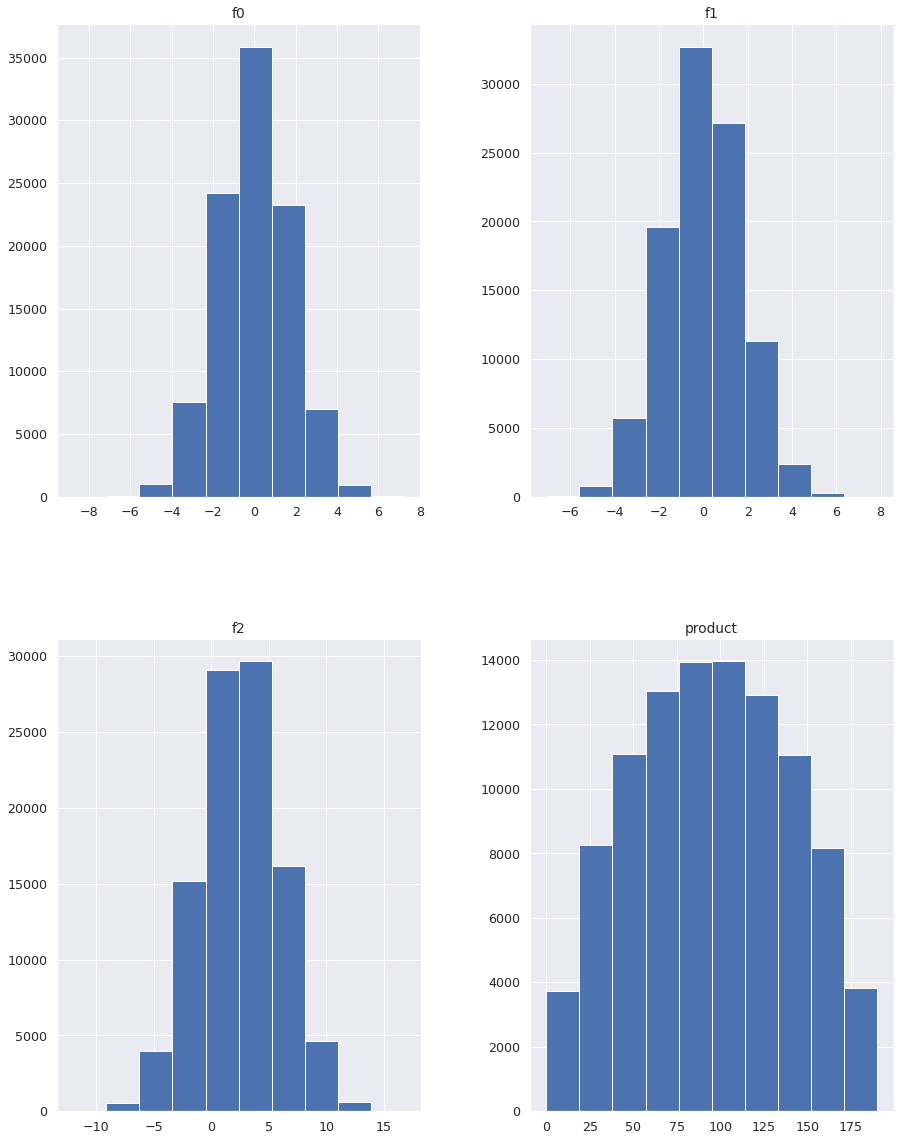

In [111]:
df_2.hist(figsize=(15, 20));

Профили регионов-0 и 2 похожи друг на друга и на нормальное распределение по трем характеристикам/признакам скважин (f0, f1, f2) и объемам запасов скважин с медианой и средним ок. 100. 
<br><br> Регион-1 отличается от них: заметно более низкой медианой и средней запасов - ок. 60 и большим стандартным отклонением параметра f1 из-за большого диапазона значений, который он принимает в этом регионе, а также распределеним f2 напоминающим случайное при малом диапазоне значений (т.е. параметр f2 в регионе 1 принимает почти равновероятно принимает значения от 0 до 5).
<br><br>
Т.к. в Регионе-1 параметры скважин и запасы нефти не распределены нормально, сравнение средних с помощью t-критерия не подойдет. 

In [112]:
df_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [113]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [114]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<AxesSubplot:>

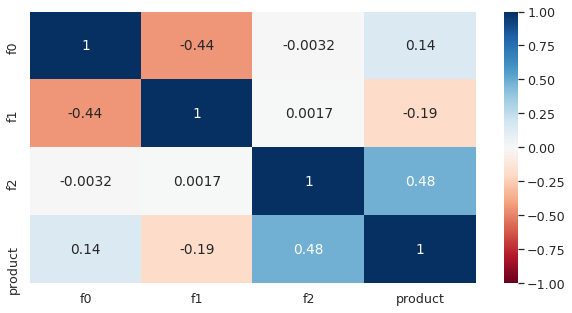

In [115]:
# проверим нет ли корреляций между параметрами
sns.set(font_scale=1.15)
plt.figure(figsize=(10,5))
sns.heatmap(
    df_0.corr(),        
    cmap='RdBu', 
    annot=True, 
    vmin=-1, vmax=1)

<AxesSubplot:>

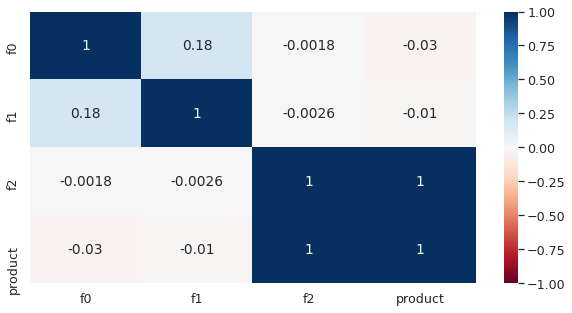

In [116]:
# проверим нет ли корреляций между параметрами
sns.set(font_scale=1.15)
plt.figure(figsize=(10,5))
sns.heatmap(
    df_1.corr(),        
    cmap='RdBu', 
    annot=True, 
    vmin=-1, vmax=1)

<AxesSubplot:>

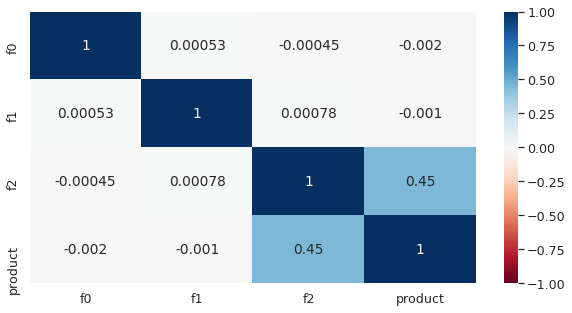

In [117]:
# проверим нет ли корреляций между параметрами
sns.set(font_scale=1.15)
plt.figure(figsize=(10,5))
sns.heatmap(
    df_2.corr(),        
    cmap='RdBu', 
    annot=True, 
    vmin=-1, vmax=1)

В регионе 0 сильная отрицательная корреляция (-0.44) м-ду признаками f0 и f1 (это приведет к мультиколлинеарности в модели линейной регресии).
<br><br>
В регионе 1 слабая положительная корреляция (0.18) м-ду признаками f0 и f1. Важнее что между прзнаком f2 и прогнозируемой переменной - объемам запасов в скважине корреляция 1. В остальных регионах признак f2 также заметно сильнее прочих коррелирует с объемами запасов. На первый взгляд может показаться, что этих наблюдений без модели достаточно, чтобы сделать вывод, что регион-1 для разработки скважен менее перспективен, чем регионы 0 и 2, т.к. в регионе-1 медианное значение f2 заметно ниже, чем в других регионах. 
<br><br>
Выше было отмечено, что максимальное значения признака f2 в регионе-1 - 5 (причем практически равновероятно это значения от 0 до 5), тогда как в регионах 0 и 2 максимальные значения f2 - 16 и 16.7, соответственно (аналогично соотношение медиан и хотя и не средних этого параметра). Однако корреляция признака f2 c запасами, напротив, чуть выще в регионе-0 (0.48), чем в регионе-1 (0.45), поэтому сказать без модели, какой регион перспективнее для разработки, сложно.
<br><br>
Учитывая сравнительно более высокую корреляцию признаков f0 и f1 для региона 0, можно предположить, что модель на основе линейной регрессии будет точнее (с меньшим RMSE) именно для этого региона (однако в ней будет мультиколлинеарность). Проверим эти гипотизы из разведовательного анализа данных.  

## Обучение и проверка модели

In [118]:
# разделим признаки (на фичи и таргет)

target_0 = df_0['product']
features_0 = df_0.drop('product', axis=1)

target_1 = df_1['product']
features_1 = df_1.drop('product', axis=1)

target_2 = df_2['product']
features_2 = df_2.drop('product', axis=1)

In [119]:
# разобьем выборки на обучающую (75%) и валидационную (25%)

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=12345)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=12345)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=12345)

print(features_train_0.shape)
print(features_valid_0.shape)
print()
print(features_train_1.shape)
print(features_valid_1.shape)
print()
print(features_train_2.shape)
print(features_valid_2.shape)

(75000, 3)
(25000, 3)

(75000, 3)
(25000, 3)

(75000, 3)
(25000, 3)


In [120]:
# посмотрим
display(features_valid_1.head())

,f0,f1,f2
71751,-0.371866,-1.862494,3.002210
80493,9.015122,-13.881455,1.995363
2655,-6.507568,-4.817448,1.003449
53233,14.560845,-10.667755,1.995175
91141,6.090476,-4.494723,0.013815


In [121]:
# масштабируем фичи региона-0

numeric = ['f0', 'f1', 'f2']
scaler_0 = StandardScaler()
scaler_0.fit(features_train_0[numeric]);
features_train_0[numeric] = scaler_0.transform(features_train_0[numeric]);
features_valid_0[numeric] = scaler_0.transform(features_valid_0[numeric]);

import warnings
warnings.filterwarnings("ignore")


In [122]:
display(features_valid_0.head())

,f0,f1,f2
71751,0.517917,-0.610097,-0.126226
80493,0.568391,-0.086063,-0.814914
2655,0.805688,-1.613289,-1.341342
53233,0.222503,-1.355437,-0.597275
91141,-0.087941,1.433113,-0.544588


In [123]:
# масштабируем фичи региона-1
numeric = ['f0', 'f1', 'f2']
scaler_1 = StandardScaler()
scaler_1.fit(features_train_1[numeric]);
features_train_1[numeric] = scaler_1.transform(features_train_1[numeric]);
features_valid_1[numeric] = scaler_1.transform(features_valid_1[numeric]);

warnings.filterwarnings("ignore")

In [124]:
display(features_valid_1.head())

,f0,f1,f2
71751,-0.168616,0.571372,0.297471
80493,0.878384,-1.772903,-0.293901
2655,-0.852976,-0.004986,-0.876502
53233,1.496940,-1.146077,-0.294011
91141,0.552177,0.057961,-1.457764


In [125]:
# масштабируем фичи региона-2
numeric = ['f0', 'f1', 'f2']
scaler_2 = StandardScaler()
scaler_2.fit(features_train_2[numeric]);
features_train_2[numeric] = scaler_2.transform(features_train_2[numeric]);
features_valid_2[numeric] = scaler_2.transform(features_valid_2[numeric]);

warnings.filterwarnings("ignore")

In [126]:
display(features_valid_2.head())

,f0,f1,f2
71751,-0.836717,-2.227439,-0.078489
80493,-0.821648,0.740237,-1.000811
2655,-2.651336,-0.235721,-0.244546
53233,1.077998,0.938090,0.511313
91141,-1.173938,2.387270,1.034363


In [127]:
# модель (линейная регрессия по условию) для региона-0
model_0 = LinearRegression() 
model_0.fit(features_train_0, target_train_0) # обучение модели на тренировочной выборке
predictions_valid_0 = model_0.predict(features_valid_0) # получение предсказаний на валидационной выборке

RMSE_0 = mean_squared_error(target_valid_0, predictions_valid_0)**0.5
print("средний запас предсказанного сырья в регионе-0 :", round(predictions_valid_0.mean()))
print("RMSE модели линейной регрессии на валидационной выборке в регионе-0 :", round(RMSE_0, 2))

средний запас предсказанного сырья в регионе-0 : 93
RMSE модели линейной регрессии на валидационной выборке в регионе-0 : 37.58


In [128]:
# модель (линейная регрессия по условию) для региона-1
model_1 = LinearRegression() 
model_1.fit(features_train_1, target_train_1) # обучите модель на тренировочной выборке
predictions_valid_1 = model_1.predict(features_valid_1) # получите предсказания модели на валидационной выборке

RMSE_1 = mean_squared_error(target_valid_1, predictions_valid_1)**0.5
print("средний запас предсказанного сырья в регионе-1 :", round(predictions_valid_1.mean()))
print("RMSE модели линейной регрессии на валидационной выборке в регионе-1 :", round(RMSE_1, 2))

средний запас предсказанного сырья в регионе-1 : 69
RMSE модели линейной регрессии на валидационной выборке в регионе-1 : 0.89


In [129]:
# модель (линейная регрессия по условию) для региона 2
model_2 = LinearRegression() 
model_2.fit(features_train_2, target_train_2) # обучите модель на тренировочной выборке
predictions_valid_2 = model_2.predict(features_valid_2) # получите предсказания модели на валидационной выборке

RMSE_2 = mean_squared_error(target_valid_2, predictions_valid_2)**0.5
print("средний запас предсказанного сырья в регионе-2 :", round(predictions_valid_2.mean()))
print("RMSE модели линейной регрессии на валидационной выборке в регионе-2 :", round(RMSE_2, 2))

средний запас предсказанного сырья в регионе-2 : 95
RMSE модели линейной регрессии на валидационной выборке в регионе-2 : 40.03


In [130]:
def regression (features_train, features_valid, target_train, target_valid):
    model = LinearRegression() 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid) 

    RMSE = mean_squared_error(target_valid, predictions_valid)**0.5
    return pd.Series(predictions_valid), RMSE
    

In [131]:
# использовал функцию для региона-0

predictions_valid_0, RMSE_0 = regression(features_train_0, features_valid_0, target_train_0, target_valid_0)

print("средний запас предсказанного сырья в регионе-0 :", round(predictions_valid_0.mean()))
print("RMSE модели линейной регрессии на валидационной выборке в регионе-0 :", round(RMSE_0, 2))

средний запас предсказанного сырья в регионе-0 : 93
RMSE модели линейной регрессии на валидационной выборке в регионе-0 : 37.58


In [132]:
# использовал функцию для региона-1

predictions_valid_1, RMSE_1 = regression(features_train_1, features_valid_1, target_train_1, target_valid_1)

print("средний запас предсказанного сырья в регионе-0 :", round(predictions_valid_1.mean()))
print("RMSE модели линейной регрессии на валидационной выборке в регионе-0 :", round(RMSE_1, 2))

средний запас предсказанного сырья в регионе-0 : 69
RMSE модели линейной регрессии на валидационной выборке в регионе-0 : 0.89


In [133]:
# использовал функцию для региона-1

predictions_valid_2, RMSE_2 = regression(features_train_2, features_valid_2, target_train_2, target_valid_2)

print("средний запас предсказанного сырья в регионе-0 :", round(predictions_valid_2.mean()))
print("RMSE модели линейной регрессии на валидационной выборке в регионе-0 :", round(RMSE_2, 2))

средний запас предсказанного сырья в регионе-0 : 95
RMSE модели линейной регрессии на валидационной выборке в регионе-0 : 40.03


**Промежуточный вывод:** Средний запас предсказанного сырья в регионе-1 (69) заметно ниже, чем в регионе-0 (93) и регионе-2 (95). Однако заметно ниже и квадратный корень из средней квадратичной ошибки модели (RMSE): всего 0.89 для модели для региона-1 по сравнению с 37.58 для модели для региона-0 и 40.03 - для региона-2. Т.е. разработка скважин в регионе-1 дает хорошо предсказуемые, однако в среднем невысокие объемы добычи, тогда как разработка в регионе-0 и регионе-2 в заметно более высокие в среднем, однако недостаточно хорошо предсказуемые объемы добычи. (В случае ошибки предиктивной модели объемы добычи в регионах 0 и 2 в худшем случае могут оказаться ниже предсказуемо низких в регионе-1: ок. 55 против 68, соответственно). 
<br><br>
Необходимо понять, являются ли хорошо предсказуемые, однако низкие объемы добычи в регионе-1 безубыточными, или безубыточность, а не только высокая прибыль, требует рисков связанных с плохой предсказуемостью, но высокими запасами сырья в скважинах регионов 0 и 2. (В случае, если предиктивная модель занижает предпологаемые объемы, прибыли от разработки регионов 0 и 2 будуг гораздо выше региона-1).    

## Подготовка к расчёту прибыли

In [134]:
# вводные данные по условию:
BUDG_PER_REG = 10e9 # бюджет на разработку скважин в регионе
N_PER_REG = 200 # скважин разрабатывают в регионе

BUDG_PER_1 = BUDG_PER_REG / N_PER_REG # затраты на разработку одной скважины в регионе
REV_PER_UNIT = 450_000 # доход с каждой единицы продукта (продукт в тыс.брл., т.к. объем запасов скважины в тыс.брл.)
BREAK_EVEN_STOCK = round(BUDG_PER_1/REV_PER_UNIT, 2) # порог безубыточных запасов в скважине

print("достаточный объём сырья для безубыточной разработки новой скважины :", BREAK_EVEN_STOCK)


достаточный объём сырья для безубыточной разработки новой скважины : 111.11


**Промежуточный вывод:** Во всех трех регионах средний прогнозируемый запас сырья в скважине (регион-0 (93), регион-1 (69), регион-2 (95)) ниже минимально необходимого объема сырья для безубыточной разработки 1 новой скважины (111.11).   
   

Прежде чем отбирать лучшие скважины и рассчитывать прибыть, в df-ы c региональными данными необходимо добавить столбцы с прогнозами запасов нефти в каждой скважине, сделаные с помощью соответствующих моделей, обученных только на обучающих выборках.  
<br><br>
Делаю это, чтобы избежать задачи соотнесения индексов прогнозов и реальных объемов всех скважаин в каждом регионе. В кадом df создал новому столбцу и заполнил их предсказаниями моделей (обученных на общающей выборке), но делающей предсказания по всем соответствующим фичам региона (от о до 99999) которые сохранены в features_0, features_1 и features_2  до разделения их на train и valid для каждого региона соответственно (features_train_0 и features_valid_0 и т.д.). Такое заполнение сохранит соответствие по индексам.

In [135]:
# добавляем соответствующие столбцы в df-ы 

# масштабируем фичи регионов features_$ с помощью scalar_$ уже обученными выше только на обучающей выборке 
numeric = ['f0', 'f1', 'f2']
features_0[numeric] = scaler_0.transform(features_0[numeric])
features_1[numeric] = scaler_1.transform(features_1[numeric])
features_2[numeric] = scaler_2.transform(features_2[numeric])

# добавляем стобец в df_$['predicted_product'] в который кладем model_$.predict(features_$)
# соответствующие модели для регионов обучены в предыдущем шаге только на соответствующих обучающих выборках
df_0['predicted_product'] = model_0.predict(features_0)
df_1['predicted_product'] = model_1.predict(features_1)
df_2['predicted_product'] = model_2.predict(features_2)



In [136]:
# посмотрим на результат
display(df_0.sample(10))
df_0.info()

,f0,f1,f2,product,predicted_product
65494,0.690469,0.672300,-0.727753,133.838383,66.061192
37969,1.959342,0.399661,0.514016,112.046530,82.650847
55049,1.441876,-0.464847,2.783019,181.952204,107.939399
24272,-0.155802,0.874114,-0.801104,104.275043,59.691925
56309,1.890768,0.362871,6.998307,163.126282,125.675153
63478,0.523208,-0.468389,3.420218,82.665034,108.889888
25088,0.337745,0.023103,1.563193,87.229113,89.050863
83671,-0.411985,0.815034,7.287336,143.233226,112.932857
91650,1.707581,-0.090658,-0.417600,59.083394,82.516518
47729,-0.956309,0.401016,1.458054,36.857314,78.380575


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   f0                 100000 non-null  float64
 1   f1                 100000 non-null  float64
 2   f2                 100000 non-null  float64
 3   product            100000 non-null  float64
 4   predicted_product  100000 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB


In [137]:
display(df_1.sample(10))

,f0,f1,f2,product,predicted_product
10958,-11.713908,4.471722,2.991274,84.038886,83.872960
44948,5.662411,-4.197986,5.002326,134.766305,135.745619
98704,-10.927847,0.032450,2.000997,57.085625,57.167695
59285,-15.442734,2.538850,-0.000107,3.179103,3.834751
76468,-1.196818,-12.667683,1.000782,30.132364,29.080043
22789,-3.139801,-9.736477,1.997625,57.085625,56.163186
12217,16.012682,6.138592,1.995741,53.906522,52.986734
18116,-9.426936,-11.954986,2.984784,84.038886,83.728418
56332,4.379459,-7.696069,1.998913,53.906522,55.063102
89658,8.256836,0.038488,4.001681,107.813044,108.307717


Для региона-1 особенно хорошо видно, что соответствие индексов соблюдено, т.к. модель предсказывает с пренебрежительно малым RMSE и различие м-ду product и predicted_product минимально  

In [138]:
display(df_2.sample(10))

,f0,f1,f2,product,predicted_product
69250,0.362048,-0.371566,1.060565,153.242852,86.857553
37884,-0.337431,1.313312,2.525726,0.179795,95.129289
61125,0.922007,-0.848622,10.729635,84.548944,142.091150
3422,3.029154,-1.004263,-1.886170,94.236696,70.144994
86182,-0.012363,-0.074320,-2.180213,29.752497,68.333404
40204,1.315414,1.041026,5.699125,75.728443,113.307309
60505,0.570941,-1.801323,4.478266,145.973508,106.433981
58577,-0.948142,-1.032541,3.616067,80.109347,101.432892
70556,0.812759,0.948578,1.152252,23.724982,87.339612
78413,2.978323,1.882759,4.790295,148.533722,108.135408


## Расчёт прибыли и рисков 

In [140]:
# 4.1.Выберите скважины с максимальными значениями предсказаний - сколько? (200)
df_0_top200_predict = df_0.sort_values(by='predicted_product', ascending = False).head(200)
display(df_0_top200_predict)

,f0,f1,f2,product,predicted_product
51140,1.092258,-0.541900,16.003790,182.079984,194.936305
83095,1.888221,0.067384,15.428372,144.009283,185.412580
51464,1.612452,-0.074593,15.230322,173.971897,185.117595
93073,1.814871,-0.207268,14.087536,162.810993,180.180713
52356,0.879559,0.258449,15.202838,123.920559,177.608048
...,...,...,...,...,...
96634,0.892427,-0.528988,10.415690,166.875679,157.193055
89983,1.172767,0.305634,12.038409,153.801308,157.132668
48192,1.550545,-0.195269,10.761237,120.584452,157.131039
49683,0.792516,-0.557116,10.398348,185.010308,157.116304


In [141]:
# добавим столбец с прибылью из 200 с максимальными предсказаниями по реальным объемам 

df_0_top200_predict['profit'] = (df_0_top200_predict['product'] * REV_PER_UNIT)- BUDG_PER_1

In [142]:
display(df_0_top200_predict.sample(5))

,f0,f1,f2,product,predicted_product,profit
13413,1.348169,-0.434621,10.909253,83.357783,160.754201,-1.248900e+07
48992,1.051818,-0.424715,10.725472,145.451035,158.338120,1.545297e+07
14786,2.076069,0.333083,11.666124,169.174308,157.536539,2.612844e+07
21654,0.635486,-0.331524,11.503988,141.473023,160.661400,1.366286e+07
15353,0.000765,0.139868,12.685261,133.678102,159.523656,1.015515e+07


In [143]:
df_0_top200_predict.describe()

,f0,f1,f2,product,predicted_product,profit
count,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02
mean,1.136109,-0.261504,11.768629,149.934491,163.217735,1.747052e+07
std,0.585125,0.334853,1.151700,23.496899,5.773705,1.057360e+07
min,-1.088629,-0.721746,9.878737,58.420650,157.111862,-2.371071e+07
25%,0.794608,-0.508063,10.910223,138.518964,159.226680,1.233353e+07
50%,1.131863,-0.375296,11.501647,153.171961,161.386015,1.892738e+07
75%,1.586752,-0.120075,12.408795,167.242744,165.698528,2.525923e+07
max,2.196539,0.884469,16.003790,185.010308,194.936305,3.325464e+07


Среднее значение прибыли каждой скважины из 200 скважин с максимальными значениями предсказаний в регионе-0 ок. 17 млн. р., стандартное отклонение ок. 10 млн.р. (Скважина  с минимальным объемом из этих 200 (58 тыс. брл.) для которой прогноз оказался сильно завышенным будет убыточной). 

In [144]:
print("суммарная прибыль 200 скважин с максимальными значениями предсказаний в регионе-0:", 
      round(sum(df_0_top200_predict['profit'])/ 10**9, 1), 'млрд. р.')

суммарная прибыль 200 скважин с максимальными значениями предсказаний в регионе-0: 3.5 млрд. р.


In [145]:
# для региона-1 (если весь бюджет идет на 200 а не 500 скважин)
df_1_top200_predict = df_1.sort_values(by='predicted_product', ascending = False).head(200)
df_1_top200_predict['profit'] = (df_1_top200_predict['product'] * REV_PER_UNIT)- BUDG_PER_1
df_1_top200_predict.describe()

,f0,f1,f2,product,predicted_product,profit
count,200.000000,200.000000,200.000000,2.000000e+02,200.000000,2.000000e+02
mean,-17.454631,-7.715054,5.001902,1.379454e+02,139.162291,1.207543e+07
std,2.050664,4.541973,0.005244,5.698606e-14,0.255698,3.734639e-09
min,-26.646255,-21.827682,4.988211,1.379454e+02,138.895998,1.207543e+07
25%,-18.826992,-10.688653,4.998158,1.379454e+02,138.978525,1.207543e+07
50%,-17.069183,-7.718043,5.001951,1.379454e+02,139.076399,1.207543e+07
75%,-16.109616,-4.946081,5.005232,1.379454e+02,139.291524,1.207543e+07
max,-13.110444,4.523771,5.015957,1.379454e+02,140.359367,1.207543e+07


Среднее значение прибыли каждой скважины из 200 скважин с максимальными значениями предсказаний в регионе-1 ок. 12 млн. р., стандартное отклонение пренебрежительно мало. (Соответственно, завышение и занижение прогноза моделью практически отсутствует). 

In [146]:
print("суммарная прибыль 200 скважин с максимальными значениями предсказаний в регионе-1:", 
      round(sum(df_1_top200_predict['profit'])/ 10**9, 1), 'млрд. р.')

суммарная прибыль 200 скважин с максимальными значениями предсказаний в регионе-1: 2.4 млрд. р.


In [147]:
# для региона-2
df_2_top200_predict = df_2.sort_values(by='predicted_product', ascending = False).head(200)
df_2_top200_predict['profit'] = (df_2_top200_predict['product'] * REV_PER_UNIT)- BUDG_PER_1
df_2_top200_predict.describe()

,f0,f1,f2,product,predicted_product,profit
count,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02
mean,0.022196,-0.107039,13.222745,139.682340,156.264284,1.285705e+07
std,1.663291,1.753950,0.897730,27.458490,5.119915,1.235632e+07
min,-4.065346,-3.969345,12.315142,47.575997,151.238236,-2.859080e+07
25%,-1.043047,-1.343905,12.620246,124.936026,152.785023,6.221212e+06
50%,-0.037558,-0.122118,12.876061,141.402421,154.287795,1.363109e+07
75%,1.239070,1.034646,13.588655,159.836352,158.309209,2.192636e+07
max,4.024527,4.076270,16.739402,187.769619,176.120799,3.449633e+07


Среднее значение прибыли каждой скважины из 200 скважин с максимальными значениями предсказаний в регионе-2 ок. 12 млн. р., стандартное отклонение ок. 12 млн.р. (Скважина с минимальным фактическим объемом из этих 200 (47.5 тыс. брл.), для которой прогноз оказался сильно завышенным, будет убыточной.

In [148]:
print("суммарная прибыль 200 скважин с максимальными значениями предсказаний в регионе-2:", 
      round(sum(df_2_top200_predict['profit'])/ 10**9, 1), 'млрд. р.')

суммарная прибыль 200 скважин с максимальными значениями предсказаний в регионе-2: 2.6 млрд. р.


**Промежуточный вывод:** суммарная прибыль 200 скважин с максимальными предсказаниями (из всех 10000 скважин каждого региона, а не из 500 случайно отобранных 1000 раз) следующая: 
<br><br>
регион-0: 3.5 млрд. р.
<br>
регион-1: 2.4 млрд. р.
<br>
регион-2: 2.6 млрд. р.

### Бутстреп и ожидаемые прибыли и риски 

In [149]:
# 5. Посчитайте риски и прибыль для каждого региона

In [150]:
display(df_2.sample(10))

,f0,f1,f2,product,predicted_product
36555,-0.424958,-0.718309,3.830402,151.184365,102.659458
79938,0.730252,-1.545581,-2.127110,26.647897,68.721129
83585,-1.054350,0.791810,3.404507,153.766595,100.145510
78777,-1.295463,-2.870719,1.191057,61.812812,87.655851
32057,-0.629063,3.575756,6.244970,149.766402,116.256982
53458,1.027523,3.061345,5.597768,156.382263,112.635197
95842,-1.302027,-4.385681,11.655253,163.031221,147.454399
8772,1.802336,-1.709402,3.251074,167.862488,99.462749
62677,-0.185147,-0.516752,5.514363,34.509063,112.271400
39640,-0.477420,-1.093352,4.923009,127.780769,108.910734


### Правильный бутстреп

In [168]:
# функция подсчета прибыли и бутстреп для одного региона (региона-0)

def revenue(predictions, target, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    return (selected.sum() * REV_PER_UNIT) - BUDG_PER_REG

target_valid_0 = target_valid_0.reset_index(drop=True)    
values = []
negative_profit_count = 0
state = np.random.RandomState(12345)

for i in range(1000):
    target_subsample = target_valid_0.sample(n=500, replace=True, random_state=state)
    predictions_subsample = predictions_valid_0[target_subsample.index]
    values.append(revenue(predictions_subsample, target_subsample, 200))

values = pd.Series(values)
for value in values:
    if value < 0:
        negative_profit_count += 1
lower = values.quantile(0.025)
upper = values.quantile(0.975)
    
print('Ожидаемая средняя прибыль 200 скважин:',round(values.mean()/ 10**6),'млн. р.') 
print('Верхняя граница 95%-го доверительного интервала:', round(upper/ 10**6), 'млн. р.')
print('Нижняя граница 95%-го доверительного интервала:', round(lower/ 10**6), 'млн. р.')
print('Риск потерь:', (negative_profit_count / 1000) * 100, '%')   


Ожидаемая средняя прибыль 200 скважин: 426 млн. р.
Верхняя граница 95%-го доверительного интервала: 948 млн. р.
Нижняя граница 95%-го доверительного интервала: -102 млн. р.
Риск потерь: 6.0 %


In [169]:
# функция подсчета прибыли и функция бутстрепа для регионов

def revenue(predictions, target, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    return (selected.sum() * REV_PER_UNIT) - BUDG_PER_REG

def boot(predictions_valid, target_valid):
    target_valid = target_valid.reset_index(drop=True)
    predictions_valid = pd.Series(predictions_valid)

    values = []
    negative_profit_count = 0
    state = np.random.RandomState(12345)

    for i in range(1000):
        target_subsample = target_valid.sample(n=500, replace=True, random_state=state)
        predictions_subsample = predictions_valid[target_subsample.index]
        values.append(revenue(predictions_subsample, target_subsample, 200))

    values = pd.Series(values)
    for value in values:
        if value < 0:
            negative_profit_count += 1
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    return (values, lower, upper, negative_profit_count)
    

In [170]:
# результаты для региона-0

values, lower, upper, negative_profit_count = boot(predictions_valid_0, target_valid_0)

print('Ожидаемая средняя прибыль 200 скважин:',round(values.mean()/ 10**6),'млн. р.') 
print('Верхняя граница 95%-го доверительного интервала:', round(upper/ 10**6), 'млн. р.')
print('Нижняя граница 95%-го доверительного интервала:', round(lower/ 10**6), 'млн. р.')
print('Риск потерь:', (negative_profit_count / 1000) * 100, '%')

Ожидаемая средняя прибыль 200 скважин: 426 млн. р.
Верхняя граница 95%-го доверительного интервала: 948 млн. р.
Нижняя граница 95%-го доверительного интервала: -102 млн. р.
Риск потерь: 6.0 %


In [171]:
# результаты для региона-1

values, lower, upper, negative_profit_count = boot(predictions_valid_1, target_valid_1)

print('Ожидаемая средняя прибыль 200 скважин:',round(values.mean()/ 10**6),'млн. р.') 
print('Верхняя граница 95%-го доверительного интервала:', round(upper/ 10**6), 'млн. р.')
print('Нижняя граница 95%-го доверительного интервала:', round(lower/ 10**6), 'млн. р.')
print('Риск потерь:', (negative_profit_count / 1000) * 100, '%')

Ожидаемая средняя прибыль 200 скважин: 515 млн. р.
Верхняя граница 95%-го доверительного интервала: 932 млн. р.
Нижняя граница 95%-го доверительного интервала: 69 млн. р.
Риск потерь: 1.0 %


In [172]:
# результаты для региона-2

values, lower, upper, negative_profit_count = boot(predictions_valid_2, target_valid_2)

print('Ожидаемая средняя прибыль 200 скважин:',round(values.mean()/ 10**6),'млн. р.') 
print('Верхняя граница 95%-го доверительного интервала:', round(upper/ 10**6), 'млн. р.')
print('Нижняя граница 95%-го доверительного интервала:', round(lower/ 10**6), 'млн. р.')
print('Риск потерь:', (negative_profit_count / 1000) * 100, '%')

Ожидаемая средняя прибыль 200 скважин: 435 млн. р.
Верхняя граница 95%-го доверительного интервала: 970 млн. р.
Нижняя граница 95%-го доверительного интервала: -129 млн. р.
Риск потерь: 6.4 %


### Бутстреп датафреймов и предсказания по всем 10_000

In [173]:
# Функция для бутстрепа, которая берет на вход имена датафреймов для регионов:

def bootstrap(df):

    values = []
    negative_profit_count = 0

    state = np.random.RandomState(12345)
    for i in range(1000):
        df_subsample = df.sample(n=500, replace=True, random_state=state)
        df_subsample_200 = df_subsample.sort_values(by='predicted_product', ascending = False).head(200)
        values.append((df_subsample_200['product'].sum() * REV_PER_UNIT) - BUDG_PER_REG)
    

    values = pd.Series(values)
    for value in values:
        if value < 0:
            negative_profit_count += 1
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    return (values, lower, upper, negative_profit_count)  



In [71]:
# результаты для региона-2:

values, lower, upper, negative_profit_count = bootstrap(df_2)

print('Ожидаемая средняя прибыль 200 скважин:',round(values.mean()/ 10**6),'млн. р.') 
print('Верхняя граница 95%-го доверительного интервала:', round(upper/ 10**6), 'млн. р.')
print('Нижняя граница 95%-го доверительного интервала:', round(lower/ 10**6), 'млн. р.')
print('Риск потерь:', (negative_profit_count / 1000) * 100, '%')

Ожидаемая средняя прибыль 200 скважин: 374 млн. р.
Верхняя граница 95%-го доверительного интервала: 896 млн. р.
Нижняя граница 95%-го доверительного интервала: -182 млн. р.
Риск потерь: 9.2 %


In [72]:
# результаты для региона-1:

values, lower, upper, negative_profit_count = bootstrap(df_1)

print('Ожидаемая средняя прибыль 200 скважин:',round(values.mean()/ 10**6),'млн. р.') 
print('Верхняя граница 95%-го доверительного интервала:', round(upper/ 10**6), 'млн. р.')
print('Нижняя граница 95%-го доверительного интервала:', round(lower/ 10**6), 'млн. р.')
print('Риск потерь:', (negative_profit_count / 1000) * 100, '%')

Ожидаемая средняя прибыль 200 скважин: 449 млн. р.
Верхняя граница 95%-го доверительного интервала: 824 млн. р.
Нижняя граница 95%-го доверительного интервала: 37 млн. р.
Риск потерь: 1.4000000000000001 %


In [73]:
# результаты для региона-0:

values, lower, upper, negative_profit_count = bootstrap(df_0)

print('Ожидаемая средняя прибыль 200 скважин:',round(values.mean()/ 10**6),'млн. р.') 
print('Верхняя граница 95%-го доверительного интервала:', round(upper/ 10**6), 'млн. р.')
print('Нижняя граница 95%-го доверительного интервала:', round(lower/ 10**6), 'млн. р.')
print('Риск потерь:', (negative_profit_count / 1000) * 100, '%')

Ожидаемая средняя прибыль 200 скважин: 424 млн. р.
Верхняя граница 95%-го доверительного интервала: 969 млн. р.
Нижняя граница 95%-го доверительного интервала: -78 млн. р.
Риск потерь: 5.2 %


## Вывод

Ожидаемая средняя прибыль 200 скважин оказалась несколько выше в регионе-1 (449 млн. р.), чем в регионе-0 (424 млн. р.) и регионе-2 (374 млн. р.). При этом риск потерь в регионе-1 (1.4%) заметно ниже, чем в регионе-0 (9.2%) и регионе-2 (5.2%). Поэтому следует выбрать регион-1, даже несмотря на то, что максимальные запасы и максимальные прибыли выше в регионах-0 и 2.  